# Chose 4 different regression techniques

## Read data
Only one file awailable, test dataset will be a part of the main dataset:
`data/diamonds/diamonds.csv`

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import metrics

from itertools import combinations

/usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Metrics function
Function prints out different metrics of the predictions.
- MAE
- MAPE
- RMSE
- R2

In [111]:
def print_metrics(y_hat, y_test):
    output = pd.DataFrame({'MAE': [round(np.mean(abs(y_hat-y_test)), 2)],
                   'MAPE': [round(np.mean(abs(y_hat-y_test)/y_test), 4)],
                   'RMSE': [round(np.sqrt(np.mean((y_test - y_hat)**2)), 2)],
                   ' R2': [round(metrics.r2_score(y_test, y_hat),2)]
                   })
    return output

In [68]:
diamonds = pd.read_csv('data/diamonds/diamonds.csv')
diamonds.drop('Unnamed: 0', axis=1, inplace=True)

In [69]:
newDiamonds = pd.DataFrame(columns=diamonds.columns)
for p,q in zip(diamonds['price'].quantile(q=[x/100. for x in range(100)]),
            diamonds['price'].quantile(q=[x/100. for x in range(1,101)])):
    my_set = (diamonds.loc[(diamonds['price'] >= p) & (diamonds['price'] < q)].sample(27*2, random_state=42))
    
    newDiamonds=newDiamonds.append(my_set,ignore_index=True)
diamonds=newDiamonds

### Check data
`info()` method shows if there are missing values
it shows that there aren't any missing values (non-null for every feature)

In [74]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5400 entries, 0 to 5399
Data columns (total 27 columns):
carat            5400 non-null float64
depth            5400 non-null float64
table            5400 non-null float64
price            5400 non-null object
x                5400 non-null float64
y                5400 non-null float64
z                5400 non-null float64
cut_Good         5400 non-null int64
cut_Ideal        5400 non-null int64
cut_Very Good    5400 non-null int64
cut_Premium      5400 non-null int64
cut_Fair         5400 non-null int64
color_F          5400 non-null int64
color_J          5400 non-null int64
color_I          5400 non-null int64
color_E          5400 non-null int64
color_G          5400 non-null int64
color_D          5400 non-null int64
color_H          5400 non-null int64
clarity_SI2      5400 non-null int64
clarity_VS2      5400 non-null int64
clarity_VVS1     5400 non-null int64
clarity_SI1      5400 non-null int64
clarity_VS1      5400 non-nul

## Preprocessing (without scaling)
Preprocessing is needed because data contains ordinal features. We have now two possibilities to encode them:
- one Hot encoding: every unique value gets its own feature
- label encoding: every value gets a number assigned (implies that the features have ratio-scale)

### Label encoding

In [58]:
cuts = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
colors = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
clarities = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
diamonds['cut'] = diamonds['cut'].apply(lambda x: cuts.index(x))
diamonds['color'] = diamonds['color'].apply(lambda x: colors.index(x))
diamonds['clarity'] = diamonds['clarity'].apply(lambda x: clarities.index(x))

### One Hot encoding

In [71]:
for key in diamonds.keys():
    if diamonds[key].dtype == 'object':
        uniques = diamonds[key].unique()
        for unique in uniques:
            diamonds[key + '_' + unique] = diamonds[key].apply(lambda x: 1 if x == unique else 0)
        diamonds.drop(key, axis=1, inplace=True)

TypeError: can only concatenate str (not "int") to str

In [75]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5400 entries, 0 to 5399
Data columns (total 27 columns):
carat            5400 non-null float64
depth            5400 non-null float64
table            5400 non-null float64
price            5400 non-null object
x                5400 non-null float64
y                5400 non-null float64
z                5400 non-null float64
cut_Good         5400 non-null int64
cut_Ideal        5400 non-null int64
cut_Very Good    5400 non-null int64
cut_Premium      5400 non-null int64
cut_Fair         5400 non-null int64
color_F          5400 non-null int64
color_J          5400 non-null int64
color_I          5400 non-null int64
color_E          5400 non-null int64
color_G          5400 non-null int64
color_D          5400 non-null int64
color_H          5400 non-null int64
clarity_SI2      5400 non-null int64
clarity_VS2      5400 non-null int64
clarity_VVS1     5400 non-null int64
clarity_SI1      5400 non-null int64
clarity_VS1      5400 non-nul

## Feature Pearson Correlation

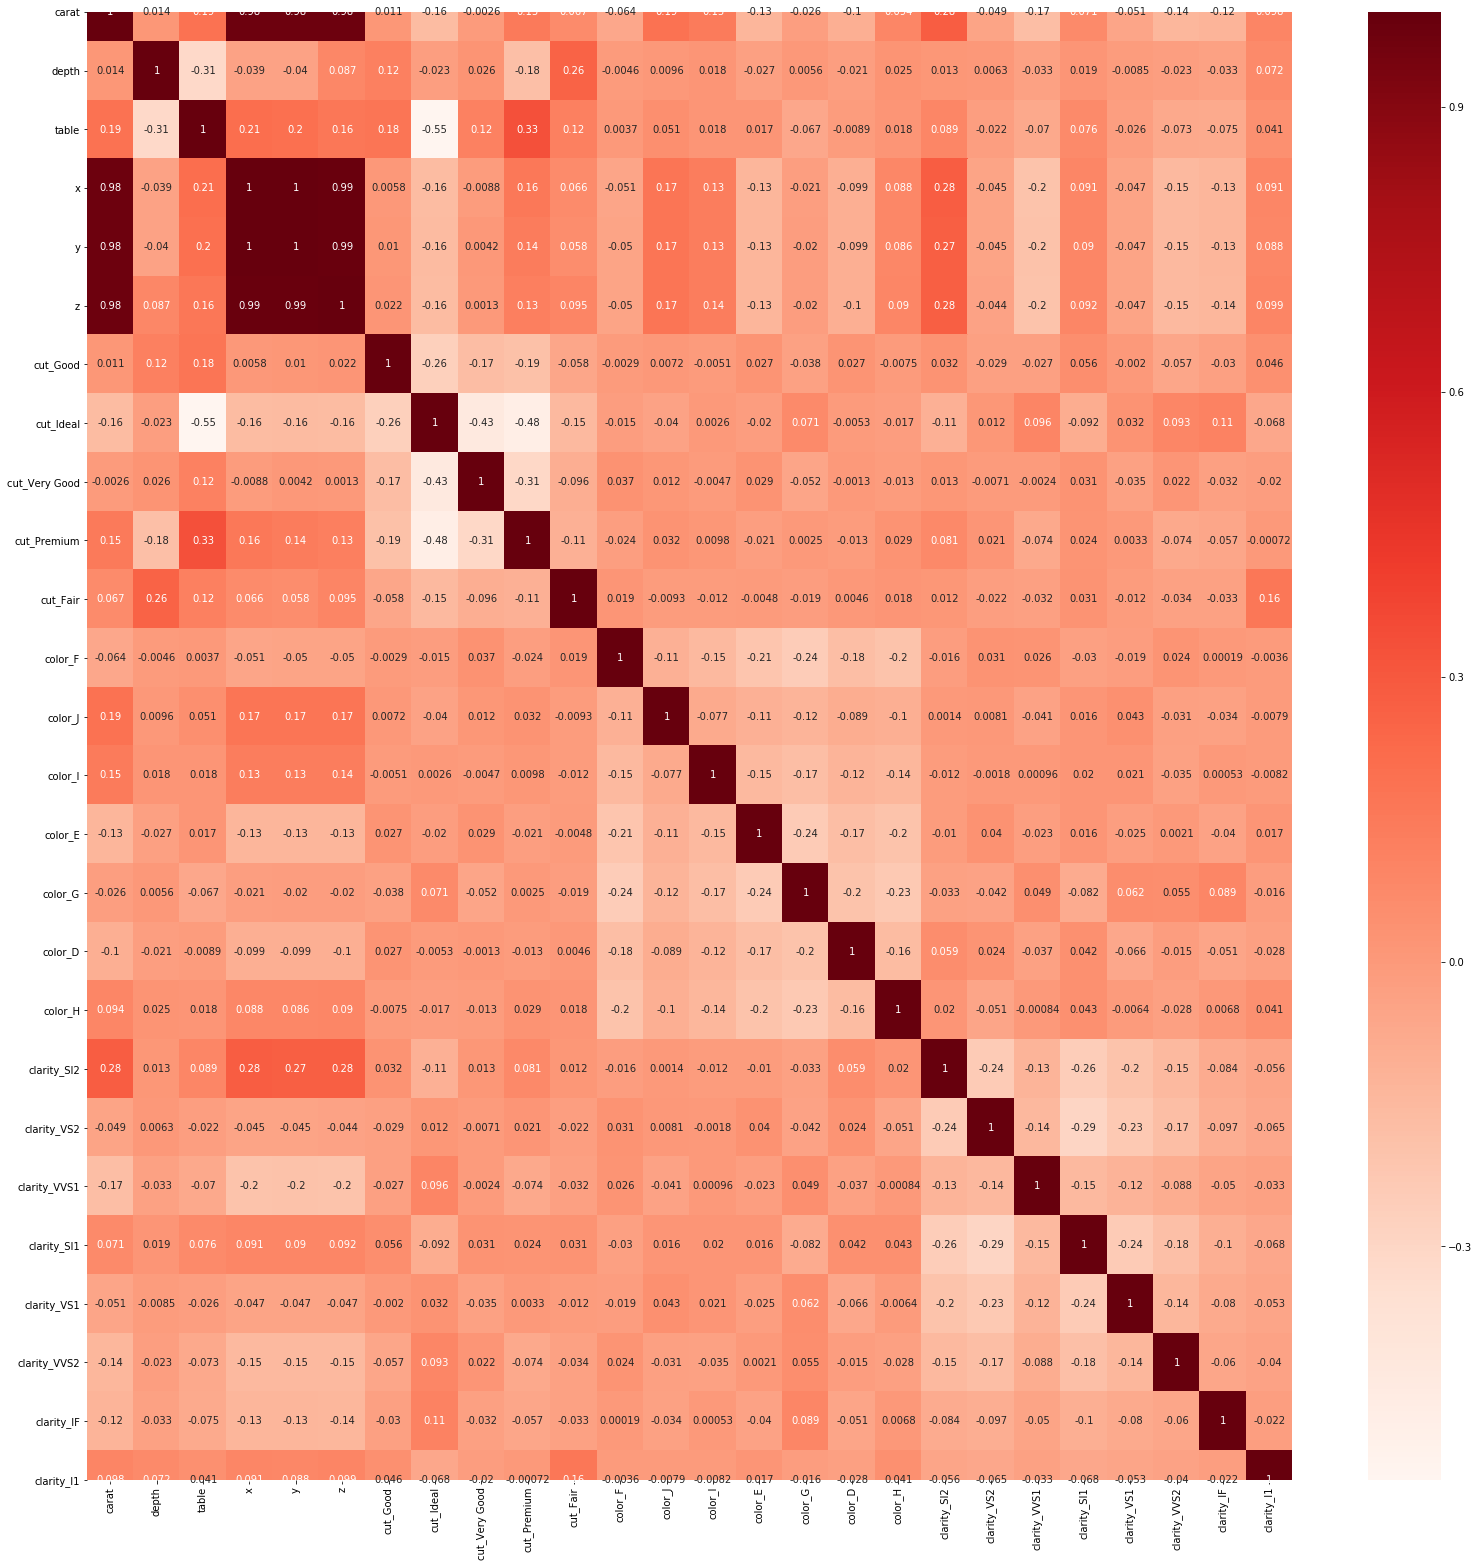

In [76]:
plt.figure(figsize=(27,27))
cor = diamonds.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.savefig('diamonds_feature_correlation.png')
plt.show()

## Creating feature and target arrays

In [77]:
#diamonds_dropped = diamonds.drop(['x'], axis = 1)
diamonds_dropped = diamonds

In [78]:
X = diamonds_dropped.drop('price', axis = 1).values
y = diamonds_dropped['price'].values

## Creating train and test data 


In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## Starting with a simple model to:
+ get a sense of how challenging the problem is
+ many more things might go wrong with complex models
+ how much signal can we pull out using basic models

## Ridge regression
__Score history:__
- Test set RMSE of rf: 1201.245 (base version, label encoding)
- Test set RMSE of rf: 1125.839 (one hot encoding, changed train/test from 70/30 to 50/50)
- Test set RMSE of rf: 1063.317

### Ridge parameters
- __alpha:__
    - regularization strenght: the higher the value, the stronger the regularization
- __fit_intercept:__
    - weather to calculate an intercept for this model (e. g. not needed if centered) 
- __normalize:__
    - if `fit_intercept` and `normalize` are both `True` the regressor X will be normalized

In [81]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [135]:
# create parameter list for ridge regression
params_ridge = {
    'alpha':[x/100. for x in range(0,500,10)],
    'normalize': [True, False],
    'fit_intercept': [True]
}

ridge = Ridge()

In [136]:
# setup cross validation parameter grid search
grid_ridge = GridSearchCV(estimator=ridge,
    param_grid=params_ridge,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1)

In [137]:
# fitting model on training data
grid_ridge.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.55004e-18): result may not be accurate.
  overwrite_a=True).T
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.4s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                   0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
                                   1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
                                   2.7, 2.8, 2.9, ...],
                         'fit_intercept': [True], 'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)

In [138]:
# extracting best parameters (can be used for finer hyper parameter tuning)
grid_ridge.best_params_

{'alpha': 0.5, 'fit_intercept': True, 'normalize': False}

In [139]:
# predicting values and calculating the rmse-score
y_pred_ridge = grid_ridge.predict(X_test)
rmse_test_ridge = MSE(y_test, y_pred_ridge)**(1/2)
print('Test set RMSE of rf: {:.3f}'.format(rmse_test_ridge))

Test set RMSE of rf: 1063.317


In [141]:
print_metrics(y_test, y_pred_ridge)

,MAE,MAPE,RMSE,R2
0,710.79,-0.0277,1063.32,0.92


In [165]:
# To use with Pycharm and dark theme
plt.style.use('ggplot')

#to increase font size
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 27}

plt.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


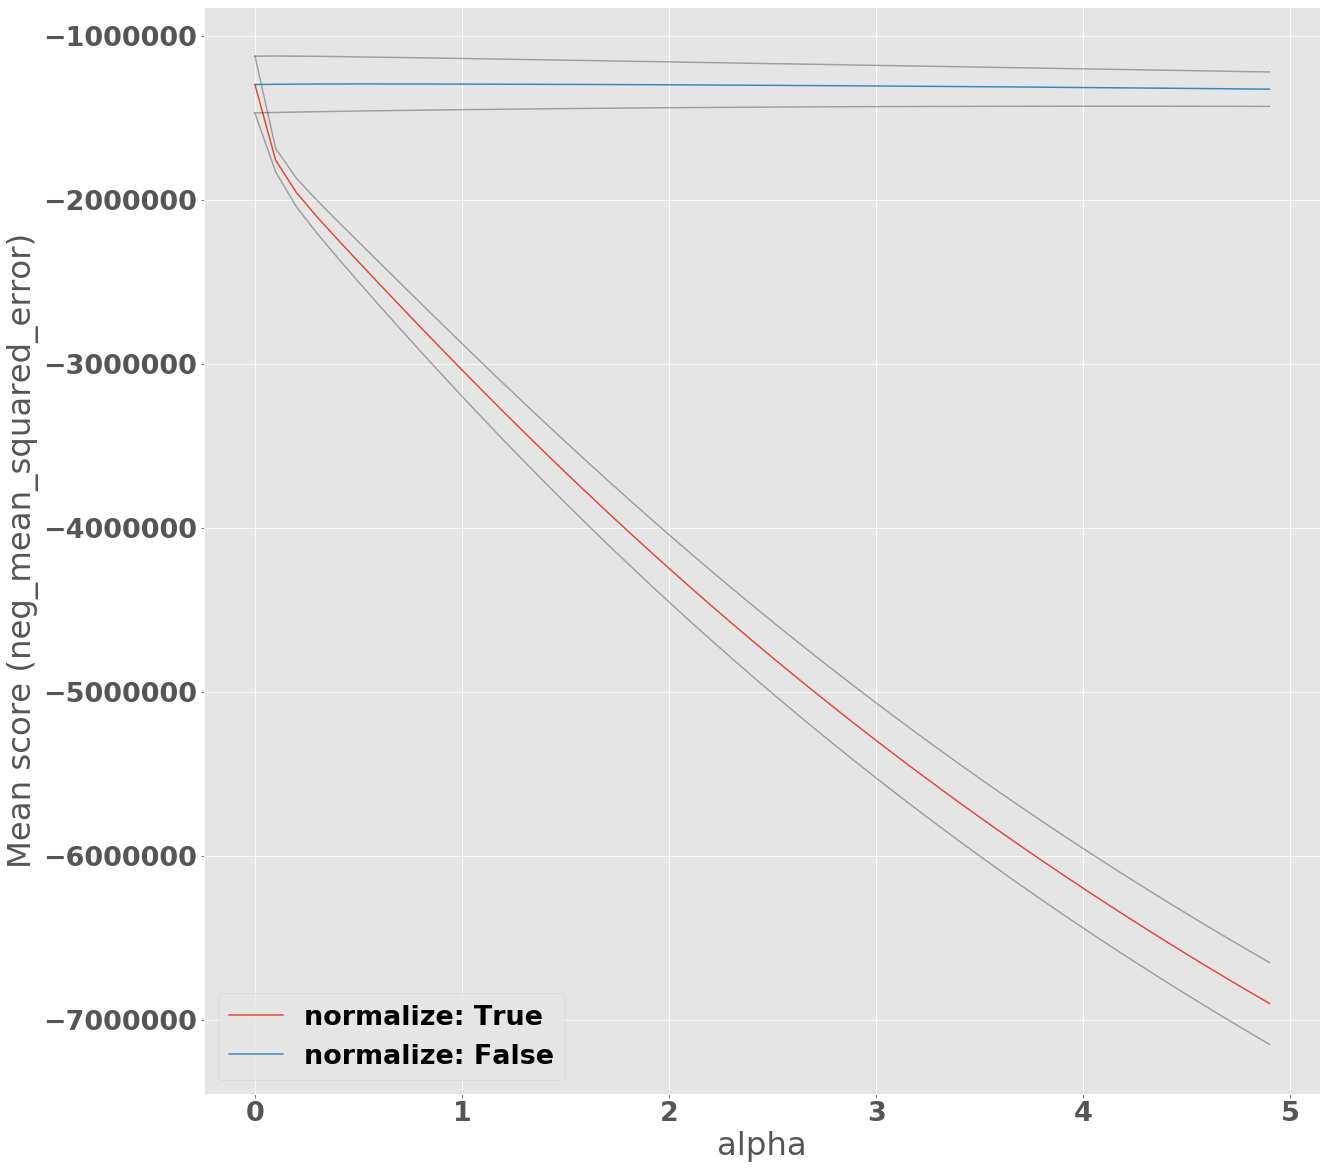

In [166]:
params = params_ridge
grid = grid_ridge
param1_name = 'normalize'
param2_name = 'alpha'
param1 = params[param1_name]
param2 = params[param2_name]

scores_df = pd.DataFrame(grid.cv_results_)

scores_mean = [x for x in scores_df['mean_test_score']]
scores_mean = np.array(scores_mean).reshape(len(param2), len(param1))
scores_mean = np.swapaxes(scores_mean,0,1)
scores_std = [x for x in scores_df['std_test_score']]
scores_std = np.array(scores_std).reshape(len(param2), len(param1))
scores_std = np.swapaxes(scores_std,0,1)

plt.figure(figsize=(20, 20))
for ind, i in enumerate(param1):
    plt.plot(param2, scores_mean[ind], label=param1_name+': ' + str(i))
    plt.plot(param2, scores_mean[ind] + scores_std[ind], color='black', alpha=0.3)
    plt.plot(param2, scores_mean[ind] - scores_std[ind], color='black', alpha=0.3)
plt.legend()
plt.xlabel(param2_name)
plt.ylabel('Mean score (neg_mean_squared_error)')
plt.show()

## Lasso regression
__Score history:__
- Test set RMSE of rf: 1201.65 (base version, label encoding)
- Test set RMSE of rf: 1125.88 (one hot encoding, changed train/test from 70/30 to 50/50)
- Test set RMSE of rf: 1060.77

### Lasso Parameters:
- __alpha:__
    - constant that multiplies the L1-Norm
- __fit_intercept:__
    - weather to calculate an intercept for this model (e. g. not needed if centered) 
- __normalize:__
    - if `fit_intercept` and `normalize` are both `True` the regressor X will be normalized
- __positive:__
    - when `True` forces the coefficients to be positive

In [87]:
from sklearn.linear_model import Lasso

In [129]:
params_lasso = {
    'alpha': [0.001, 0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2],
    'normalize': [True, False],
    'fit_intercept': [True],
    'positive': [False] 
}

lasso = Lasso()

In [130]:
grid_lasso = GridSearchCV(estimator=lasso,
    param_grid=params_lasso,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1)

In [131]:
grid_lasso.fit(X_train, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1347204117.1779053, tolerance: 4042500.9179523434
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1538894738.7098324, tolerance: 4052451.817571071
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1564383205.1702564, tolerance: 3986942.5133065064
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not conve

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 725388252.0859756, tolerance: 4052451.817571071
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 603409905.9671319, tolerance: 3986942.5133065064
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 525639973.4108412, tolerance: 4042500.9179523434
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 653479902.7909

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.001, 0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                   0.7, 0.8, 0.9, 1, 1.1, 1.2],
                         'fit_intercept': [True], 'normalize': [True, False],
                         'positive': [False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)

In [132]:
grid_lasso.best_params_

{'alpha': 0.001, 'fit_intercept': True, 'normalize': False, 'positive': False}

In [92]:
y_pred_lasso = grid_lasso.predict(X_test)
rmse_test_lasso = MSE(y_test, y_pred_lasso)**(1/2)
print('Test set RMSE of rf: {:.2f}'.format(rmse_test_lasso))

Test set RMSE of rf: 1060.77


In [134]:
print_metrics(y_test, y_pred_lasso)

,MAE,MAPE,RMSE,R2
0,707.13,0.3746,1060.77,0.92


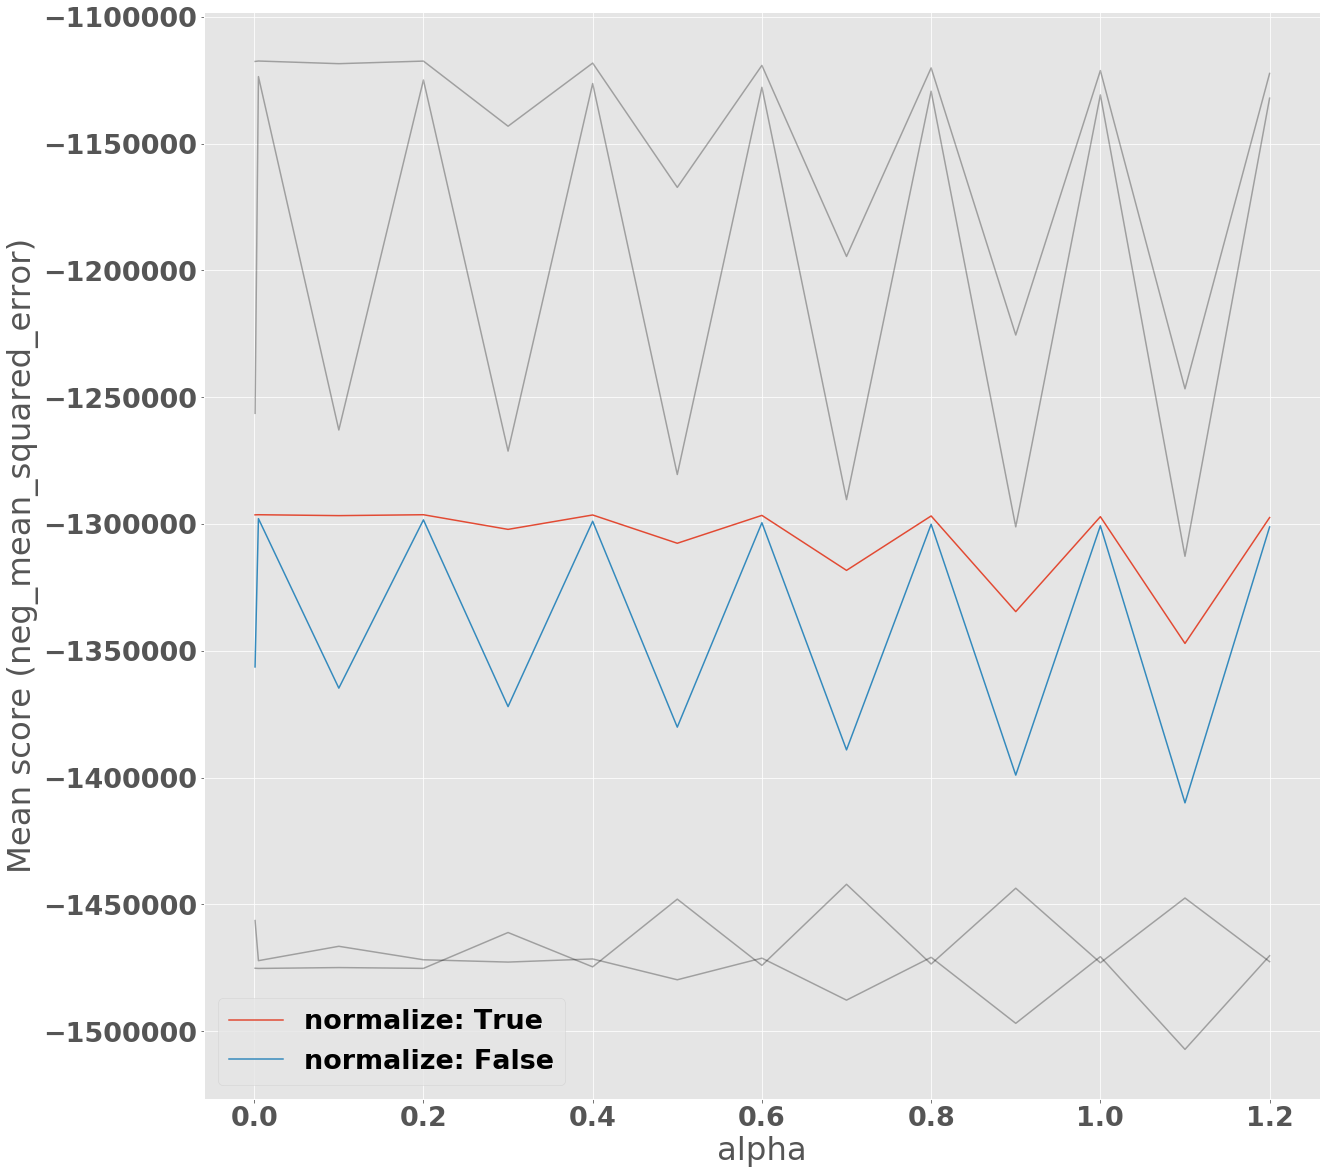

In [167]:
params = params_lasso
grid = grid_lasso
param1_name = 'alpha'
param2_name = 'normalize'
param1 = params[param1_name]
param2 = params[param2_name]

scores_df = pd.DataFrame(grid.cv_results_)

scores_mean = [x for x in scores_df['mean_test_score']]
scores_mean = np.array(scores_mean).reshape(len(param2), len(param1))
#scores_mean = np.swapaxes(scores_mean,0,1)
scores_std = [x for x in scores_df['std_test_score']]
scores_std = np.array(scores_std).reshape(len(param2), len(param1))
#scores_std = np.swapaxes(scores_std,0,1)

plt.figure(figsize=(20, 20))
for ind, i in enumerate(param2):
    plt.plot(param1, scores_mean[ind], label=param2_name+': ' + str(i))
    plt.plot(param1, scores_mean[ind] + scores_std[ind], color='black', alpha=0.3)
    plt.plot(param1, scores_mean[ind] - scores_std[ind], color='black', alpha=0.3)
plt.legend()
plt.xlabel(param1_name)
plt.ylabel('Mean score (neg_mean_squared_error)')
plt.show()

## Random Forest
__Score history:__
- Test set RMSE of rf: 536.55 (base version, label encoding)
- Test set RMSE of rf: 568.82 (one hot encoding, changed train/test from 70/30 to 50/50)

### Random Forest parameters
- __n_estimators:__
    - number of trees in the forest
- __max_depth:__
    - maximum depth of the tree
- __min_samples_split:__
    - the min. number of samples required to split an internal node
- __min_samples_leaf:__
    - the minimum number of samples required to be at a leaf node
- __min_weight_fraction_leaf:__
    - the minimum weighted fraction of the sum total of weights
- __max_features:__
    - the number of features to consider when looking for the best split
- __min_impurity_decrease:__
    - A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

In [93]:
from sklearn.ensemble import RandomForestRegressor

In [94]:
rf = RandomForestRegressor(random_state=42)

In [95]:
# take a look at the rf's parameters
print(rf.get_params())

{'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 'warn', 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [143]:
params_rf = {
    'n_estimators': [100],
    'max_depth': [None, 20, 22, 24, 26],
    'min_samples_split': [2, 3, 4]
}

grid_rf = GridSearchCV(estimator=rf,
    param_grid=params_rf,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1)

In [144]:
grid_rf.fit(X_train, y_train)


Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [None, 20, 22, 24, 26]

In [145]:
grid_rf.best_params_

{'max_depth': 22, 'min_samples_split': 3, 'n_estimators': 100}

In [146]:
y_pred = grid_rf.predict(X_test)
rmse_test = MSE(y_test, y_pred)**(1/2)
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))


Test set RMSE of rf: 684.62


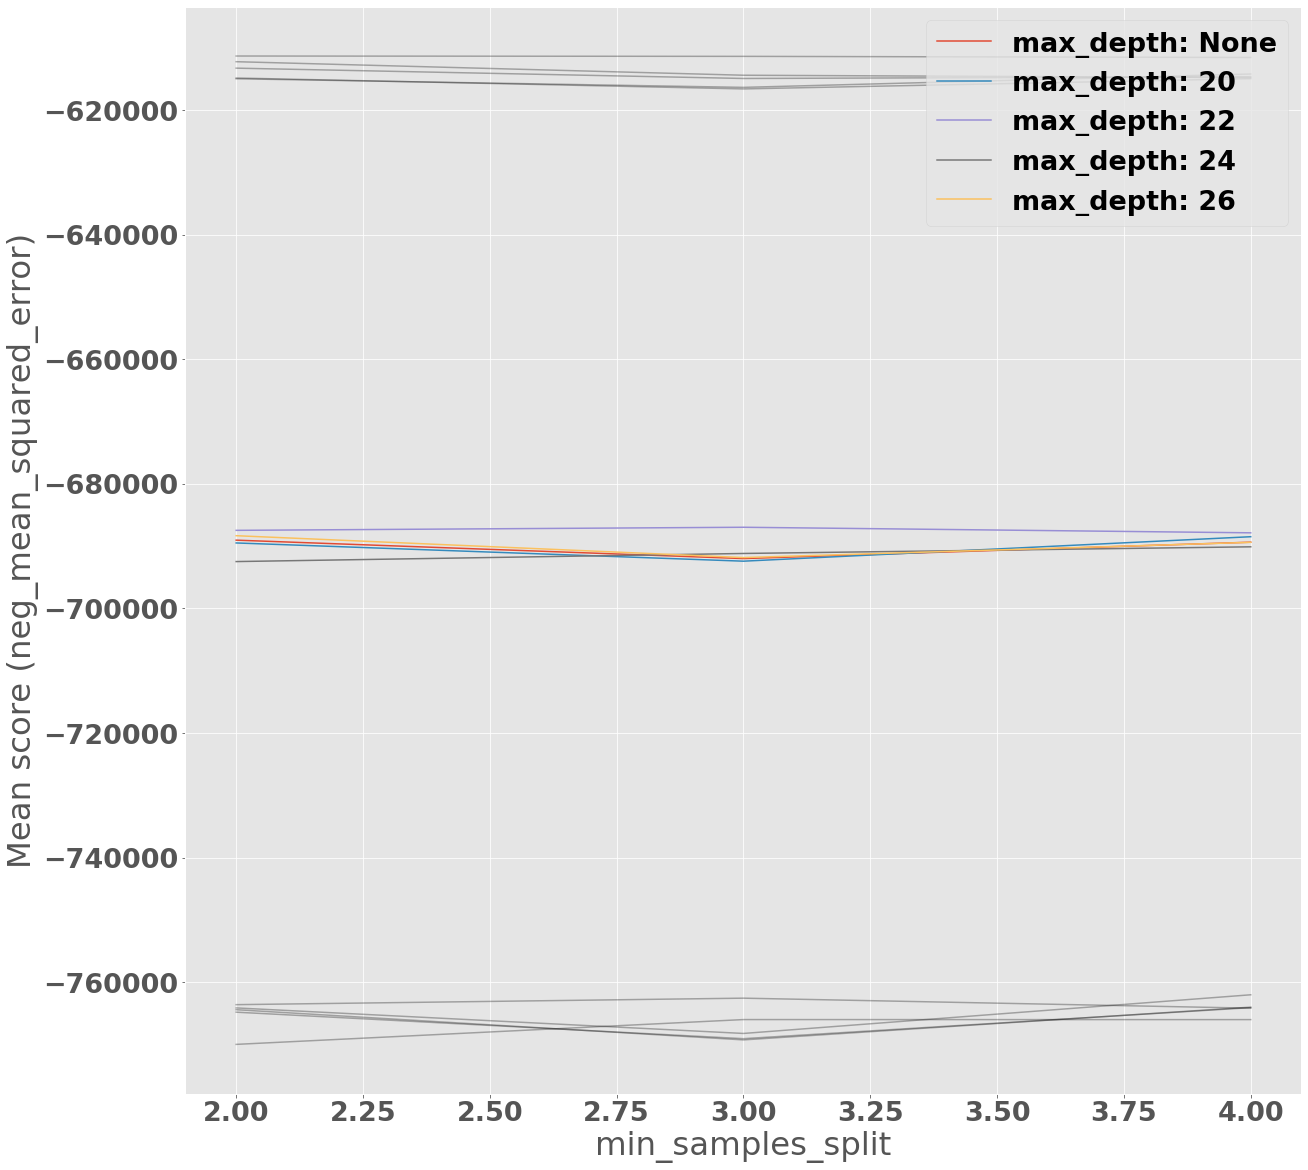

In [168]:
params = params_rf
grid = grid_rf
param1_name = 'max_depth'
param2_name = 'min_samples_split'
param1 = params[param1_name]
param2 = params[param2_name]

scores_df = pd.DataFrame(grid.cv_results_)

scores_mean = [x for x in scores_df['mean_test_score']]
scores_mean = np.array(scores_mean).reshape(len(param1), len(param2))
#scores_mean = np.swapaxes(scores_mean,0,1)
scores_std = [x for x in scores_df['std_test_score']]
scores_std = np.array(scores_std).reshape(len(param1), len(param2))
#scores_std = np.swapaxes(scores_std,0,1)

plt.figure(figsize=(20, 20))
for ind, i in enumerate(param1):
    plt.plot(param2, scores_mean[ind], label=param1_name+': ' + str(i))
    plt.plot(param2, scores_mean[ind] + scores_std[ind], color='black', alpha=0.3)
    plt.plot(param2, scores_mean[ind] - scores_std[ind], color='black', alpha=0.3)
plt.legend()
plt.xlabel(param2_name)
plt.ylabel('Mean score (neg_mean_squared_error)')
plt.show()

## Creating SVM
__Score history:__
- Test set RMSE of rf: 1495.66 (base version, one hot encoding)

### SVM parameters
- __c:__
    - penalty parameeter (higher => overfitting)
- __shrinking:__
    - weather to use the shrinking heuristic
- __kernel:__
    - specifies the kernel type

In [154]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler,MinMaxScaler

In [155]:
scaler = RobustScaler()
svr = SVR()

In [156]:
svr.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'auto_deprecated',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [157]:
pipe = make_pipeline(scaler, svr)

In [158]:
params_svr = {'svr__C': [10, 15, 1.4],
 'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
 'svr__shrinking': [True]}

grid_svr = GridSearchCV(estimator=pipe,
    param_grid=params_svr,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1)

In [159]:
grid_svr.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/loca

[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   33.8s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('minmaxscaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('svr',
                                        SVR(C=1.0, cache_size=200, coef0=0.0,
                                            degree=3, epsilon=0.1,
                                            gamma='auto_deprecated',
                                            kernel='rbf', max_iter=-1,
                                            shrinking=True, tol=0.001,
                                            verbose=False))],
                                verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'svr__C': [10, 15, 1.4],
                         'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'svr

In [160]:
grid_svr.best_params_

{'svr__C': 15, 'svr__kernel': 'linear', 'svr__shrinking': True}

In [161]:
y_pred_svr = grid_svr.predict(X_test)
rmse_test_svr = MSE(y_test, y_pred_svr)**(1/2)
print('Test set RMSE of rf: {:.2f}'.format(rmse_test_svr))


Test set RMSE of rf: 2342.57


In [152]:
print_metrics(y_pred_svr, y_test)

,MAE,MAPE,RMSE,R2
0,817.07,0.2867,1495.66,0.86


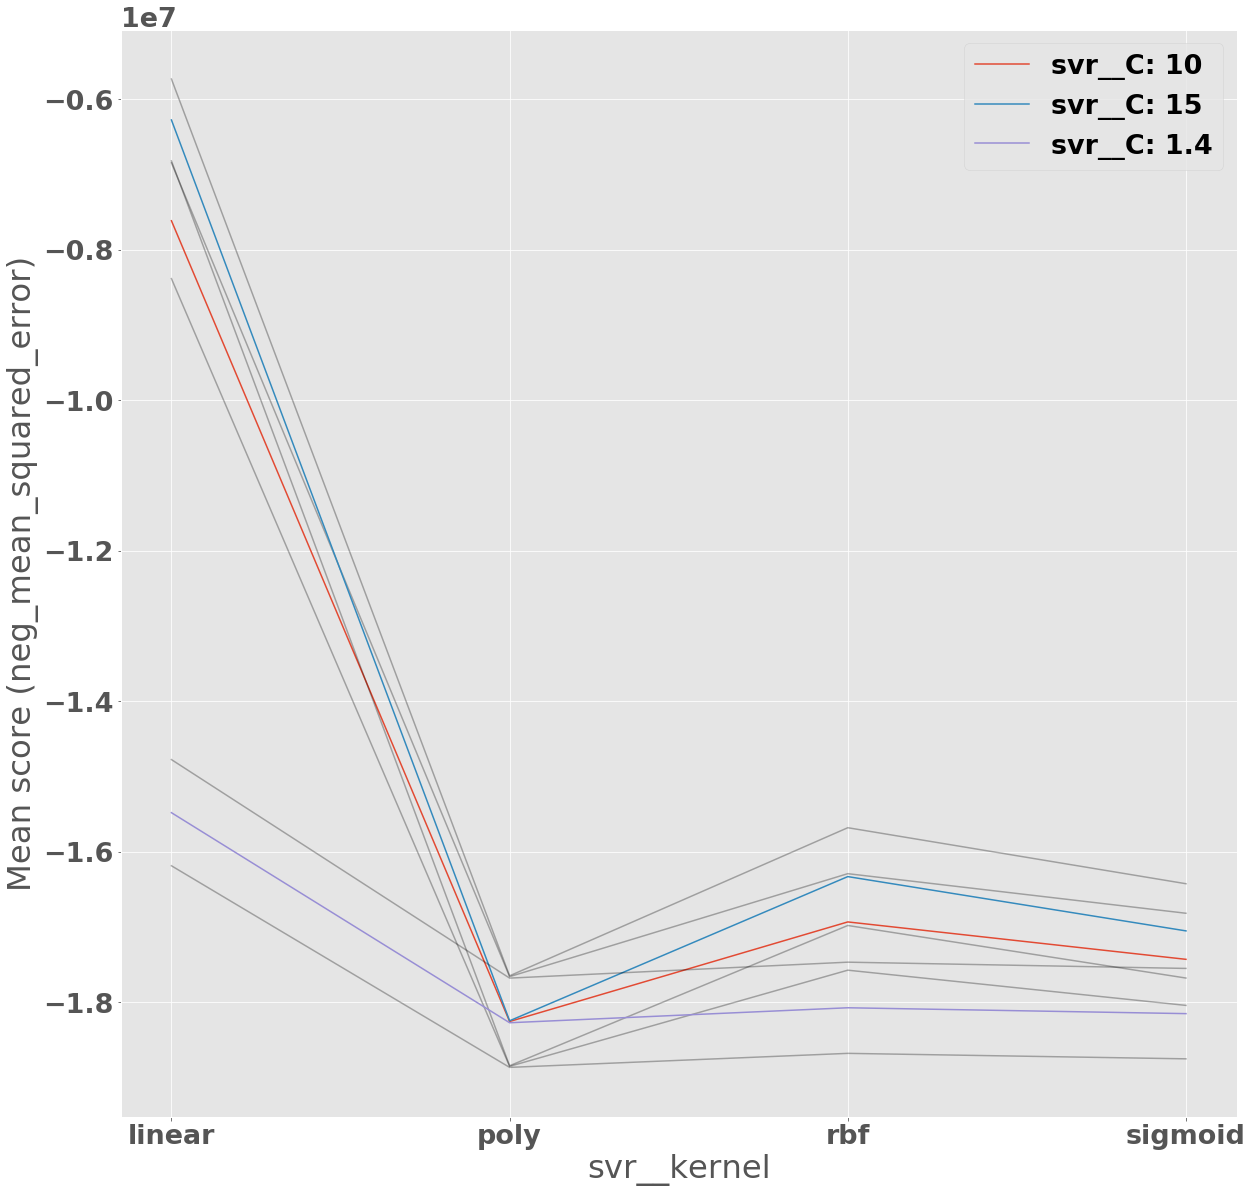

In [169]:
params = params_svr
grid = grid_svr
param1_name = 'svr__kernel'
param2_name = 'svr__C'
param1 = params[param1_name]
param2 = params[param2_name]

scores_df = pd.DataFrame(grid.cv_results_)

scores_mean = [x for x in scores_df['mean_test_score']]
scores_mean = np.array(scores_mean).reshape(len(param2), len(param1))
#scores_mean = np.swapaxes(scores_mean,0,1)
scores_std = [x for x in scores_df['std_test_score']]
scores_std = np.array(scores_std).reshape(len(param2), len(param1))
#scores_std = np.swapaxes(scores_std,0,1)

plt.figure(figsize=(20, 20))
for ind, i in enumerate(param2):
    plt.plot(param1, scores_mean[ind], label=param2_name+': ' + str(i))
    plt.plot(param1, scores_mean[ind] + scores_std[ind], color='black', alpha=0.3)
    plt.plot(param1, scores_mean[ind] - scores_std[ind], color='black', alpha=0.3)
plt.legend()
plt.xlabel(param1_name)
plt.ylabel('Mean score (neg_mean_squared_error)')
plt.show()

## Creating a GradientBoostingRegressor
__Score history:__
- Test set RMSE of rf: 678.63 (base version, label encoding)
- Test set RMSE of rf: 643.24 (one hot encoding)

In [113]:
from sklearn.ensemble import GradientBoostingRegressor

In [114]:
gbt = GradientBoostingRegressor(random_state=42)


In [115]:
params_gbt = {
'n_estimators': [200],
'max_depth': [1, 2, 3, 4, 5, 6, 7],
'max_features': ['log2'],
'learning_rate': [0.05, 0.1, 0.15],
'subsample': [0.8]
    
}
# Instantiate 'grid_rf'
grid_gbt = GridSearchCV(estimator=gbt,
param_grid=params_gbt,
cv=3,
scoring='neg_mean_squared_error',
verbose=1,
n_jobs=-1)

In [116]:
grid_gbt.fit(X_train, y_train)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:   22.9s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter...
                             

In [117]:
grid_gbt.best_params_

{'learning_rate': 0.05,
 'max_depth': 6,
 'max_features': 'log2',
 'n_estimators': 200,
 'subsample': 0.8}

In [119]:
best_model = grid_gbt.best_estimator_
y_pred_gbt = best_model.predict(X_test)
rmse_test = MSE(y_test, y_pred_gbt)**(1/2)
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

Test set RMSE of rf: 643.24


In [120]:
print_metrics(y_test, y_pred_gbt)

,MAE,MAPE,RMSE,R2
0,337.39,0.0932,643.24,0.97


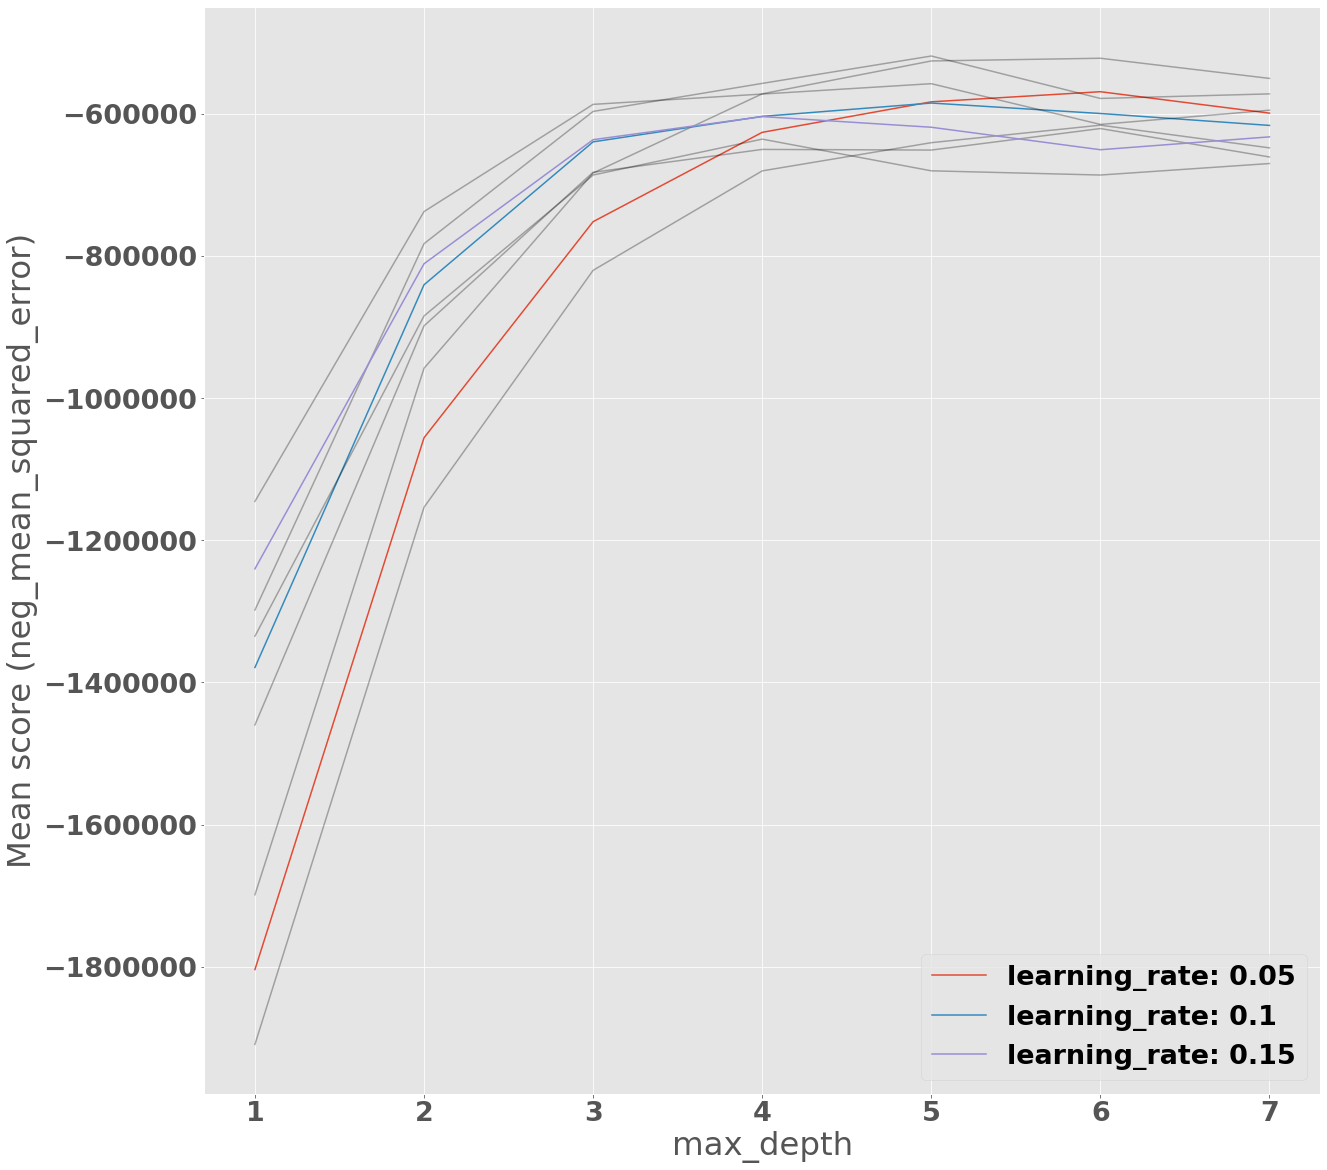

In [170]:
param1_name = 'max_depth'
param2_name = 'learning_rate'
param1 = params_gbt[param1_name]
param2 = params_gbt[param2_name]

scores_df = pd.DataFrame(grid_gbt.cv_results_)

scores_mean = [x for x in scores_df['mean_test_score']]
scores_mean = np.array(scores_mean).reshape(len(param2), len(param1))
#scores_mean = np.swapaxes(scores_mean,0,1)
scores_std = [x for x in scores_df['std_test_score']]
scores_std = np.array(scores_std).reshape(len(param2), len(param1))
#scores_std = np.swapaxes(scores_std,0,1)

plt.figure(figsize=(20, 20))
for ind, i in enumerate(param2):
    plt.plot(param1, scores_mean[ind], label=param2_name+': ' + str(i))
    plt.plot(param1, scores_mean[ind] + scores_std[ind], color='black', alpha=0.3)
    plt.plot(param1, scores_mean[ind] - scores_std[ind], color='black', alpha=0.3)
plt.legend()
plt.xlabel(param1_name)
plt.ylabel('Mean score (neg_mean_squared_error)')
plt.show()